In [3]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import json
import pandas as pd
from cpymad.madx import Madx
#from matplotlib import pyplot as plt
import NAFFlib
from math import modf
#from scipy.constants import physical_constants
from matplotlib import pyplot as plt
from scipy.stats import linregress
import math

In [4]:
#--------input and context---------

i_mo = -350
p0c = 7000e9
normal_emitt_x = 3e-6 #m*rad
normal_emitt_y = 3e-6 #m*rad
N_particles = 11 
N=1000
n_turns= 1

ctx_cpu = xo.ContextCpu()

#--------Opening the file---------

mad = Madx()
mad.option(echo=False)
mad.call('lhcandrea5.madx')
mad.use(sequence="lhcb1")
line = xt.Line.from_madx_sequence(mad.sequence['lhcb1'],
                              deferred_expressions=True
                              )
with open('hl_line.json', 'w') as fid:
    json.dump(line.to_dict(), fid, cls=xo.JEncoder)

if False:
    with open('hl_line.json', 'r') as fid:
        loaded_dct = json.load(fid)
    line = xt.Line.from_dict(loaded_dct)

#-----preparing for tracking------
#particle_0 = xp.Particles(_context=ctx_cpu, p0c=p0c)
particle_0 = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=p0c, x=1e-3, y=1e-3)
line.vars['i_mo'] = i_mo
#line.vars['cmrskew']=3*line.vars['cmrskew']
print(line.vars['i_mo']._get_value())
#print(line.vars['cmrskew']._get_value())

tracker_normal = xt.Tracker(_context=ctx_cpu, line=line)
ref = tracker_normal.find_closed_orbit(particle_0)
print(ref.x,ref.y,ref.zeta)
tw_normal = tracker_normal.twiss(ref)


betx_at_ip3 = tw_normal['betx'][0]
bety_at_ip3 = tw_normal['bety'][0]
print(betx_at_ip3,bety_at_ip3)

#----defining the sigma in both directions---------

sigma_x = np.sqrt(betx_at_ip3*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))
sigma_y = np.sqrt(bety_at_ip3*normal_emitt_y/(particle_0.gamma0*particle_0.beta0))
print(sigma_x,sigma_y)

#-----closed orbit particle-----

#p0_normal = tw_normal['particle_on_co']
p0_normal = ref 
print(p0_normal.x,p0_normal.y,p0_normal.zeta)

#-----choose one of the two to have a particle with x or y displacement----------------

#particles_normal = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
#                                     x=[mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])
particles_normal = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
                                      y=[mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

#-----tracking------------------

my_result = {}
for ii in ['x','px','y','py','zeta','delta']:
    my_result[ii] = []


for ii in range(N):
    tracker_normal.track(particles_normal, num_turns=n_turns,turn_by_turn_monitor=False)
    for jj in ['x','px','y','py','zeta','delta']:
        my_result[jj].append(getattr(particles_normal,jj).copy())       
        #my_result[jj].append(getattr(particles_normal,jj).copy())

for jj in ['x','px','y','py','zeta','delta']:
        my_result[jj] = np.array(my_result[jj])
        #my_result[jj] = np.array(my_result[jj])


#-------tunes-------

qx_normal = []
qy_normal = []

for ii in range(N_particles):
    
    qx_normal.append(NAFFlib.get_tune(my_result['x'][:,ii]))
    qy_normal.append(NAFFlib.get_tune(my_result['y'][:,ii]))

x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 
y0 = np.array([mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 

-350
generating ./7da5919bfb884fa6bae6cf1f99d3c71e.c
the current directory is '/afs/cern.ch/user/a/afornara/simulations/git_dir'
running build_ext
building '7da5919bfb884fa6bae6cf1f99d3c71e' extension
gcc -pthread -B /home/afornara/py/2022_17_03/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_17_03/miniconda/include -I/home/afornara/py/2022_17_03/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_17_03/miniconda/include -fPIC -I/home/afornara/py/2022_17_03/miniconda/include/python3.9 -c 7da5919bfb884fa6bae6cf1f99d3c71e.c -o ./7da5919bfb884fa6bae6cf1f99d3c71e.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_17_03/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_17_03/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_17_03/miniconda/lib -L/home/afornara/py/2022_17_03/miniconda/lib -L/home/afornara/py/2022_17_03/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_1

Need second attempt on closed orbit search


[2.00829648e-11] [4.06923007e-18] [13329.44159996]
121.56359711583254 218.58377591687102
[0.00022109] [0.00029647]
[2.00829648e-11] [4.06923007e-18] [13329.44159996]


17819.999999946525

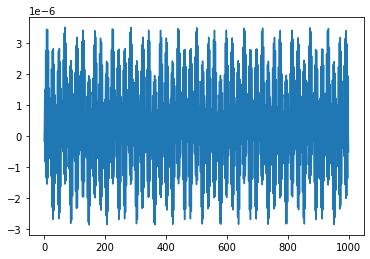

In [61]:
#print((my_result['y'][:,ii]))

plt.plot(my_result['x'][:,3])
#plt.plot(my_result['y'][:,5])
#plt.plot(tw_normal['s'],tw_normal['y'])
#len(tw_normal['betx'])
13329.44159996/(0.7480045791245792)

In [28]:
print(qy_normal)

[0.3199647919147489, 0.31985918903987093, 0.31968326137648256, 0.31943712285128767, 0.3191209303598695, 0.318734885986202, 0.31827922992692564, 0.31775424648940914, 0.3171602536699745, 0.31649760994340664, 0.31576670728784345]


In [29]:
qx_oct = [0.3099729853619833, 0.3098918357682501, 0.3097564288224855, 0.3095666905629942, 0.30932260135690787, 0.3090241960273222, 0.3086715645289171, 0.30826485287266264, 0.3078042573649851, 0.3072900293432073, 0.30672245933280956]
qx_no_oct = [0.31000247351151017, 0.3100099060222694, 0.310022318009404, 0.3100397233326097, 0.3100621477186556, 0.3100896106017297, 0.3101221338376378, 0.31015974307030975, 0.31020245464808854, 0.3102502971621292, 0.31030330628103214]
qy_oct = [0.3199647919147489, 0.31985918903987093, 0.31968326137648256, 0.31943712285128767, 0.3191209303598695, 0.318734885986202, 0.31827922992692564, 0.31775424648940914, 0.3171602536699745, 0.31649760994340664, 0.31576670728784345]
qy_no_oct = [0.320002601157878, 0.3200103963990873, 0.3200233851424917, 0.3200415710538225, 0.3200649570182308, 0.3200935416597209, 0.3201273246927187, 0.3201663161732014, 0.32021049937305646, 0.32025989443330893, 0.3203144948520657]

m =  -561357.0021162002 q =  0.3100000730788931
-538358.4126539807


1000

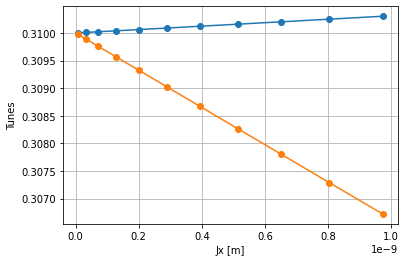

In [30]:
#Monitor detuning study, x direction
x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

jx = np.zeros(N_particles)


for ii in range(N_particles):
    jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3)



plt.plot(jx,qx_no_oct,'-o');
plt.plot(jx,qx_oct,'-o')
plt.grid()
#plt.xlim(jx[4],jx[10])
#print(j[0],dq[0],j[8],dq[8])
plt.ylabel('Tunes')
plt.xlabel('Jx [m]')


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[10]],[qx_oct[0],qx_oct[10]])
print('m = ',slope/6,'q = ',intercept)
m = ((qx_oct[10]-qx_oct[0])+(137991.53677331618*(jy[10]-jy[0])))/(jx[10]-jx[0])
print(m/6)

#print(tracker_monitor.record_last_track.x[0])
#len(tracker_monitor.record_last_track.x[0])
len(my_result['x'][:,ii])

-701999.2046298295
m =  -729293.3707357375 q =  0.31999998323203216


1000

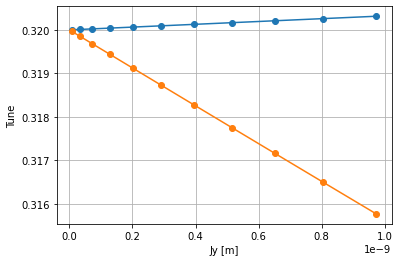

In [32]:
#Monitor detuning study, x direction
x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

jy = np.zeros(N_particles)


for ii in range(N_particles):
    jy[ii] = y0[ii]*y0[ii]/(2*bety_at_ip3)



plt.plot(jy,qy_no_oct,'-o');
plt.plot(jy,qy_oct,'-o')
plt.grid()
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])
plt.ylabel('Tune')
plt.xlabel('Jy [m]')
m = ((qy_oct[10]-qy_oct[0])+(137991.53677331618*(jx[10]-jx[0])))/(jy[10]-jy[0])
print(m/6)

slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[2]],[qy_oct[0],qy_oct[2]])
#slope = slope/6+140786.19331294773*jx[2]
print('m = ',slope/6,'q = ',intercept)

#print(tracker_monitor.record_last_track.x[0])
#len(tracker_monitor.record_last_track.x[0])
len(my_result['x'][:,ii])

In [3]:
tracker1 = xt.Tracker(_context=ctx_cpu, line=line)
#tw = tracker1.twiss(particle_0)
tw = tracker_normal.twiss(ref)

generating ./7daacffd6ebc42afa0038431fad56884.c
the current directory is '/home/afornara/studies/22_03_18/git_postprocessing'
running build_ext
building '7daacffd6ebc42afa0038431fad56884' extension
gcc -pthread -B /home/afornara/py/2022_03_18/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_18/miniconda/include -I/home/afornara/py/2022_03_18/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_18/miniconda/include -fPIC -I/home/afornara/py/2022_03_18/miniconda/include/python3.9 -c 7daacffd6ebc42afa0038431fad56884.c -o ./7daacffd6ebc42afa0038431fad56884.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_18/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_18/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_18/miniconda/lib -L/home/afornara/py/2022_03_18/miniconda/lib -L/home/afornara/py/2022_03_18/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_1

In [31]:
with open('hl_line.json', 'r') as fid:
    loaded_dct = json.load(fid)
line = xt.Line.from_dict(loaded_dct)
line.vars['i_mo'] = -350
sum_nl_x = 0.0
sum_nl_y = 0.0
sum_nl_xy = 0.0
alpha_xx= 0.0
nu_x = tw["qx"]% 1
nu_y = tw["qy"]% 1
ii = 0
for elem in line.element_dict :
    if(ii%10000 == 0):
        print('Iteration number ', ii, 'of', len(line.element_dict))
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole): 
        if(line.element_dict[elem].order==3):
                #print(elem)
                #print(line.element_dict[elem].length)
                #print(line.element_dict[elem].knl)
                sum_nl_x+=line.element_dict[elem].knl[3]*tw['betx'][ii]*tw['betx'][ii]
                sum_nl_y+=line.element_dict[elem].knl[3]*tw['bety'][ii]*tw['bety'][ii]
                sum_nl_xy+=line.element_dict[elem].knl[3]*tw['betx'][ii]*tw['bety'][ii]
        if(ii == 1): 
            break
        if(line.element_dict[elem].order==2):
            jj = 0  
            for elem2 in line.element_dict :
                if isinstance(line.element_dict[elem2],xt.beam_elements.elements.Multipole): 
                    if((line.element_dict[elem2].order==2) and (not math.isclose(line.element_dict[elem2].knl[2], 0))):
                        psi_ij_mod_x=np.abs(tw['mux'][jj]-tw['mux'][ii])
                        beta_i_beta_j = pow(tw['betx'][ii],3/2)*pow(tw['betx'][jj],3/2)
                        S_i_S_j = line.element_dict[elem].knl[2]*line.element_dict[elem2].knl[2]
                        I1 = (np.cos(3*(np.pi*nu_x-psi_ij_mod_x)))/(np.sin(3*np.pi*nu_x))
                        I2 = 3*(np.cos(np.pi*nu_x-psi_ij_mod_x)/(np.sin(np.pi*nu_x)))
                        alpha_xx += beta_i_beta_j*(S_i_S_j)*(I1)*(I2)
                        #print(alpha_xx)
                        
                        #print('elem is',elem2,'and tw[name][elem]=',tw['name'][jj],'with beta=',tw['betx'][jj], 'with knl=',line.element_dict[elem].knl[2])
                        #print(line.element_dict[elem].knl)
                        #line.element_dict[elem].knl[2]=0
                        
                jj+=1
            
    ii+=1

m_x = (sum_nl_x)/(16*np.pi)
m_y = (sum_nl_y)/(16*np.pi)
m_xy = (-sum_nl_xy)/(8*np.pi)
alpha_xx_tot = -alpha_xx/(16*np.pi)
print(m_x,m_y,m_xy,alpha_xx_tot)

Iteration number  0 of 23629
Iteration number  10000 of 23629
Iteration number  20000 of 23629
-584122.2820287823 -588765.0485519005 249339.99425447933 -7944383.525684036


- ```normal_emitt_x = 3e-6 #m*rad``` -> m
- ```sigma_x = np.sqrt(betx_at_ip3*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))``` -> sqrt(m*m/no_dimension)-> m 
- ```jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3)``` -> m*m/m -> m
- ```sum_nl_x+=line.element_dict[elem].knl[3]*tw['betx'][ii]*tw['betx'][ii]```-> $m^{-3}$(?)*$m^{2}$-> $m^{-1}$
Total dqx (no dimension) = ang_coeff ($m^{-1}$) * jx ( m ) -> no dimension = no dimension !

-392196.17098834756 -395313.78948759823 167414.16164103348

In [26]:
len(line.element_dict)

23629

In [23]:
np.abs(-2)

2

In [22]:
np.abs(tw['mux'][jj]-tw['mux'][ii])

array([ 0.        ,  0.        ,  0.        , ..., 62.29198464,
       62.29198464, 62.31000044])

-0.002743268451254721

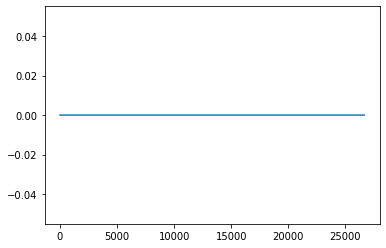

In [7]:
tw = tracker_normal.twiss(ref)
plt.plot(tw['s'],tw['y'])

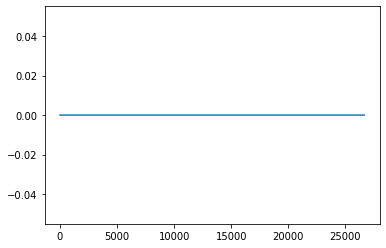

In [8]:
tw = tracker_normal.twiss(ref)
plt.plot(tw['s'],tw['x'])

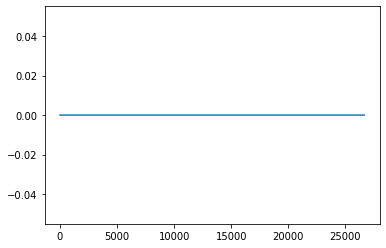

In [41]:
#tracker_normal.vars['on_sep5']=0
tw = tracker_normal.twiss(ref)
plt.plot(tw['s'],tw['y'])

In [34]:
tracker_normal.vars['on_ip5']._value

0

([<matplotlib.axis.XTick at 0x7f6356fc3ca0>], [Text(15000, 0, 'ip1')])

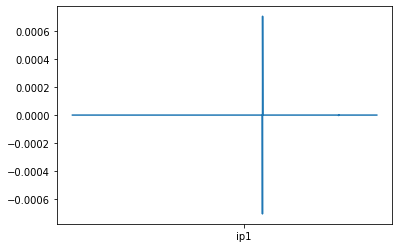

In [42]:
plt.plot(tw['s'],tw['x'])
plt.xticks([15000],['ip1'])

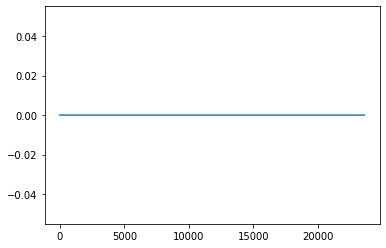

In [50]:
#tw.keys()
#tw_df = pd.DataFrame(tw)
tw_df = pd.DataFrame({'name':list(tw['name']),'x':list(tw['x']),'px':list(tw['px']),'y':list(tw['y']),'py':list(tw['py']),'zeta':list(tw['zeta']),'delta':list(tw['delta']),'betx':list(tw['betx']),'bety':list(tw['bety']),'mux':list(tw['mux']),'muy':list(tw['muy'])})
#{k:v for (k,v) in tw.items()}
plt.plot(tw_df['zeta'])

In [38]:
tw.keys()

dict_keys(['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'psigma', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'betz0', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy', 'slip_factor', 'momentum_compaction_factor', 'circumference', 'T_rev', 'R_matrix', 'particle_on_co'])

In [60]:
tracker_normal.vars['hrf400']._value
26658.8832/35640.0

0.7480045791245792

In [114]:
#--------input and context---------

i_mo = 0
p0c = 7000e9
normal_emitt_x = 3e-6 #m*rad
normal_emitt_y = 3e-6 #m*rad
N_particles = 11 
N=1000
n_turns= 1

ctx_cpu = xo.ContextCpu()

#-----preparing for tracking------

particle_0 = xp.Particles(_context=ctx_cpu, p0c=p0c)
line.vars['i_mo'] = i_mo
#line.vars['cmrs.b1_sq']=0.5*line.vars['cmrs.b1_sq']


tracker_normal = xt.Tracker(_context=ctx_cpu, line=line)
tw_normal = tracker_normal.twiss(particle_0)


betx_at_ip3 = tw_normal['betx'][0]
bety_at_ip3 = tw_normal['bety'][0]

#----defining the sigma in both directions---------

sigma_x = np.sqrt(betx_at_ip3*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))
sigma_y = np.sqrt(bety_at_ip3*normal_emitt_y/(particle_0.gamma0*particle_0.beta0))

#-----closed orbit particle-----

p0_normal = tw_normal['particle_on_co']

#-----choose one of the two to have a particle with x or y displacement----------------

particles_normal = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
                                      x=[mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])
#particles_normal = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
#y=[mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

#-----tracking------------------

my_result = {}
for ii in ['x','px','y','py','zeta','delta']:
    my_result[ii] = []


for ii in range(N):
    tracker_normal.track(particles_normal, num_turns=n_turns,turn_by_turn_monitor=False)
    for jj in ['x','px','y','py','zeta','delta']:
        my_result[jj].append(getattr(particles_normal,jj).copy())       
        #my_result[jj].append(getattr(particles_normal,jj).copy())

for jj in ['x','px','y','py','zeta','delta']:
        my_result[jj] = np.array(my_result[jj])
        #my_result[jj] = np.array(my_result[jj])


#-------tunes-------

qx_normal = []
qy_normal = []

for ii in range(N_particles):
    
    qx_normal.append(NAFFlib.get_tune(my_result['x'][:,ii]))
    qy_normal.append(NAFFlib.get_tune(my_result['y'][:,ii]))

x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 
y0 = np.array([mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 

generating ./b22bf00287044556adc68e08dc373456.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building 'b22bf00287044556adc68e08dc373456' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c b22bf00287044556adc68e08dc373456.c -o ./b22bf00287044556adc68e08dc373456.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

In [115]:
print(qx_normal)

[0.3129999811552932, 0.3129999827272727, 0.31299998534012013, 0.3129999889938052, 0.31299999368836384, 0.31299999942380374, 0.313000006200069, 0.3130000140172004, 0.31300002287519935, 0.31300003277404326, 0.31300004371376666]


In [116]:
qx_oct = [0.31298915672551, 0.31295665075936835, 0.3129023743775689, 0.31282617538611907, 0.3127278737598104, 0.31260727758286205, 0.3124642016259394, 0.3122984838368747, 0.3121099888219403, 0.3118985963358075, 0.3116642582190187]
qx_no_oct = [0.3129999811552932, 0.3129999827272727, 0.31299998534012013, 0.3129999889938052, 0.31299999368836384, 0.31299999942380374, 0.313000006200069, 0.3130000140172004, 0.31300002287519935, 0.31300003277404326, 0.31300004371376666]
qy_oct = [0.3179864018161214, 0.31794560413324036, 0.31787778537308836, 0.31778325761735776, 0.3176625376797424, 0.3175165129912427, 0.3173465326847202, 0.31715436878480313, 0.3169429411126197, 0.31671955447878025, 0.3164924105749956]
qy_no_oct = [0.31800002580777964, 0.31800002774937036, 0.3180000309853371, 0.31800003551568573, 0.318000041340406, 0.3180000484595221, 0.31800005687302935, 0.31800006658090413, 0.3180000775831715, 0.31800008987983297, 0.3180001034708594]

m =  -204822.67979319234 q =  0.3129990402376886
-202149.9212013185


1000

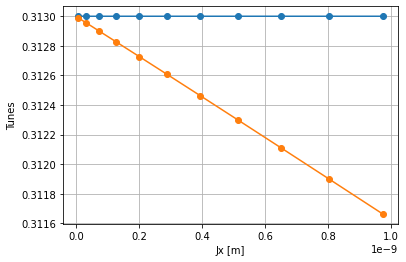

In [126]:
#Monitor detuning study, x direction
x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

jx = np.zeros(N_particles)


for ii in range(N_particles):
    jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3)



plt.plot(jx,qx_no_oct,'-o');
plt.plot(jx,qx_oct,'-o')
plt.grid()
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])
plt.ylabel('Tunes')
plt.xlabel('Jx [m]')


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[9]],[qx_oct[0],qx_oct[9]+m_xy*(jy[9]-jy[0])])
print('m = ',slope/6,'q = ',intercept)
m = ((qx_oct[4]-qx_oct[0])+(m_xy*(jy[4]-jy[0])))/(jx[4]-jx[0])
print(m/6)

# qx_oct[4]-qx_oct[0] =  mx/6(jx[4]-jx[0])/2 + mxy(jy[4]-jy[0])/2
# (2deltaq-mxy deltajy)/deltajx = mx/6

#mx = 2(qx_oct[4]-qx_oct[0])-

#2deltaqx=mxdeltajx+mxydeltajy

len(my_result['x'][:,ii])

-256187.91081631472
m =  -241724.8328416569 q =  0.3179980660045387


1000

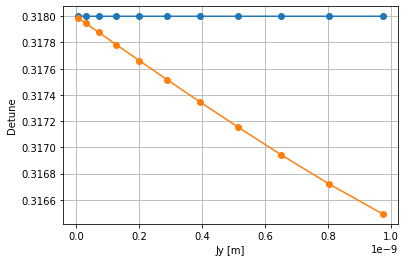

In [129]:
#Monitor detuning study, y direction
jy = np.zeros(N_particles)


for ii in range(N_particles):
    jy[ii] = y0[ii]*y0[ii]/(2*bety_at_ip3)



plt.plot(jy,qy_no_oct,'-o');
plt.plot(jy,qy_oct,'-o')
plt.grid()
plt.ylabel('Detune')
plt.xlabel('Jy [m]')
m = ((qy_oct[4]-qy_oct[0])+(m_xy*(jx[4]-jx[0])))/(jy[4]-jy[0])
print(m/6)

slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[9]],[qy_oct[0],qy_oct[9]+m_xy*(jx[9]-jx[0])])
#slope = slope/6+140786.19331294773*jx[2]
print('m = ',slope/6,'q = ',intercept)
#print(tracker_monitor.record_last_track.x[0])
#len(tracker_monitor.record_last_track.x[0])
len(my_result['x'][:,ii])